# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=15f3def9-664a-41ff-88be-6837c0922f04
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:05<00:00, 73.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=911a1054-4e39-4598-b655-ca9600ee2c16
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 190MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=5be8afee-0511-4286-8aab-92e423473362
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:00<00:00, 155MB/s]


##### Various imports

In [2]:
import torch
import pickle
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
from torchvision import transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

Now lets load the data and visualize the first few examples to see what we are dealing with!

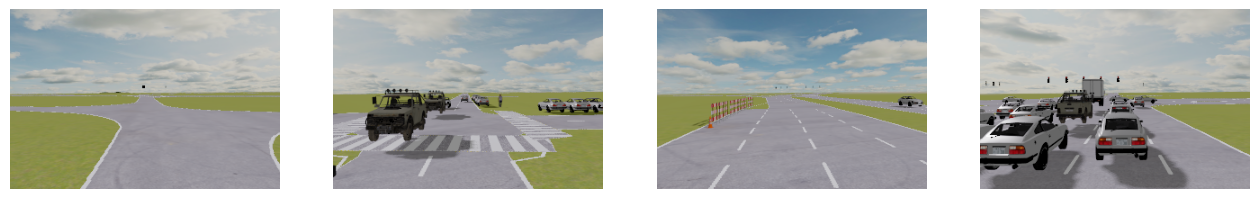

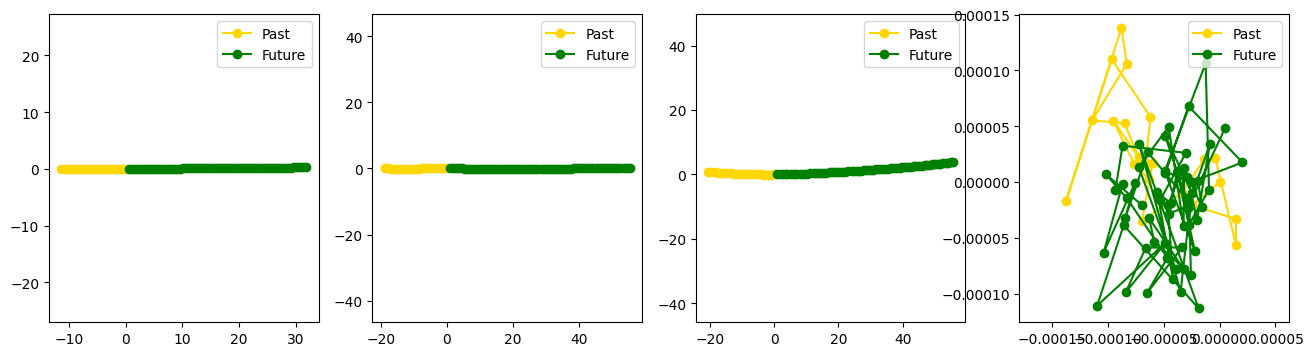

In [3]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

##### Utils

In [4]:
class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False,val=False,augment=False):
        self.samples = file_list
        self.test = test
        self.val = val
        self.augment=augment

        self.transform1 = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)
        camera = self.transform1(camera)
        history = torch.FloatTensor(data['sdc_history_feature'])
        command = data['driving_command']
        command_map = {'left':0,'right':1,'forward': 2}
        command = torch.tensor(command_map[command])

        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])

        if self.augment and random.random() < 0.5:
          camera = torch.flip(camera, dims=[2])
          history[0,:] = -history[0,:]
          future[0,:] = -future[0,:]

        if not self.test:
          return {
            'camera': camera,
            'history': history,
            'command': command,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'history': history,
            'command': command
          }

In [5]:
class Logger:
    # In this case, the logger was not used
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

##### Architecture modules

In [6]:
class CommandEncoder(nn.Module):
    """
    Pipeline for the driving_command input.
    Simple learnable embedding layer.
    Per batch;  string input
                [1xembed_dim] tensor output
    """
    def __init__(self,embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=embed_dim)

    def forward(self, command):
        return self.embedding(command)

In [7]:
class CameraEncoder(nn.Module):
    """
    Pipeline for the camera input.
    Use ResNet18 architecture, 18-layer deep CNN. First weights are freezed.
    Per batch;  [224x224x3] tensor RGB camera input
                [1xoutput_dim] tensor output
    """
    def __init__(self,output_dim=256):
        super().__init__()

        # Load pretrained ResNet18, freeze first layer and modify last to match dimensions
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for name, param in resnet.named_parameters():
            if name.startswith("conv1") or name.startswith("bn1") or name.startswith("layer1"):
                param.requires_grad = False

        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512,output_dim)

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(x.size(0), -1)  # [B,512]
        out = self.fc(features)               # [B,output_dim]
        return out

In [8]:
class HistoryEncoder(nn.Module):
    """
    Pipeline for the sdc_history_feature input.
    Use Transformer blocks, output the last timestep.
    Per batch;  [21x3] tensor position history input
                [1xd_model] tensor output
    """
    def __init__(self,d_model=128,nhead=4,num_layers=2,dropout=0.1,seq_len=21):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(seq_len, d_model))  # Learned positional embedding
        self.input_proj = nn.Linear(3, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=4*d_model,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, history):
        x = self.input_proj(history)  # [B,21,d_model]
        x = x + self.pos_embedding
        x = x.permute(1, 0, 2)
        out = self.transformer(x)
        return out[-1]  # last timestep; [B,d_model]

In [9]:
class SimpleDecoder(nn.Module):
    """
    Decode the 3 input pipeline results.
    Use concatenation and fully connected layer.
    Per batch;  processed camera, history and command input (respectively [1,camera_dim], [1,history_dim], [1,command_dim])
                [60,3] future position predictions
    """
    def __init__(self, input_dim=416, output_dim=3, sequence_length=60):
        super(SimpleDecoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim*sequence_length)

    def forward(self, camera_feat, history_feat, command_feat):

        combined_feat = torch.cat([camera_feat, history_feat, command_feat], dim=-1)  # [B,input_dim]
        future_positions_flat = self.fc(combined_feat)  # [B,60*3]
        future_positions = future_positions_flat.view(-1,60,3)

        return future_positions  # [B,60,3]

In [ ]:
class AttentionDecoder(nn.Module):
    """
    Decode the 3 input pipeline results.
    Use cross-attention blocks.
    Per batch;  processed camera, history and command input (respectively [1,camera_dim], [1,history_dim], [1,command_dim])
                [60,3] future position predictions
    """
    def __init__(self, output_dim=3, sequence_length=60,d_latent=128):
        super().__init__()
        self.d_latent=d_latent

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_latent, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_latent, output_dim*sequence_length)

        self.proj_cam = nn.Linear(256, self.d_latent)
        self.proj_hist = nn.Linear(128,self.d_latent)
        self.proj_com = nn.Linear(32,self.d_latent)

    def forward(self, camera_feat, history_feat, command_feat):

        camera_feat=self.proj_cam(camera_feat)
        history_feat=self.proj_hist(history_feat)
        command_feat=self.proj_com(command_feat)

        x = torch.stack([camera_feat, history_feat, command_feat], dim=1)
        attn_out = self.encoder(x)  # [B,3,d_model]
        fused_feat = attn_out.mean(dim=1)  # [B,d_model]
        predictions = self.fc(fused_feat)
        future_pos = predictions.view(-1, 60, 3)


        return future_pos  # [B, 60, 3]

In [ ]:
class DrivingPlanner(nn.Module):
    """
    End-to-end planner, combine all previously defined modules.
    When initialized, input the 3 features latent dimensions, dropout rate and decoder version.
    """
    def __init__(self,camera_dim,history_dim,command_dim,dropout,version):
        super().__init__()

        self.version=version

        self.camera_encoder=CameraEncoder(output_dim=camera_dim)
        self.history_encoder=HistoryEncoder(d_model=history_dim,dropout=dropout)
        self.command_encoder=CommandEncoder(embed_dim=command_dim)

        if version==1:
            self.decoder=SimpleDecoder()
        elif version==2:
            self.decoder=AttentionDecoder()

    def forward(self, camera, history, command):

        camera_feat = self.camera_encoder(camera)
        history_feat = self.history_encoder(history)
        command_feat = self.command_encoder(command)

        # Combine features
        future = self.decoder(camera_feat, history_feat, command_feat)

        return future

##### Module testing

In [12]:
# Data loading
train_data_dir = "train"
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
train_dataset = DrivingDataset(train_files,augment=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
dataiter=iter(train_loader)
batch=next(dataiter)

camera_input = batch['camera']
history_input = batch['history']
command_input = batch['command']
future_positions = batch['future']


# Model initialization and infering
camera_encoder=CameraEncoder()
history_encoder=HistoryEncoder()
command_encoder=CommandEncoder()
decoder = SimpleDecoder(input_dim=416)

camera_feat = camera_encoder(camera_input)
history_feat = history_encoder(history_input)
command_feat = command_encoder(command_input)
test_output = decoder(camera_feat, history_feat, command_feat)

loss_fn = torch.nn.MSELoss()
loss = loss_fn(test_output, future_positions)

print("Camera features:", camera_input.shape,'to', camera_feat.shape)
print("History features:",history_input.shape,'to', history_feat.shape)
print("Command features:",command_input.shape,'to', command_feat.shape)
print("Output trajectory:",future_positions.shape,'to',test_output.shape)
print("Test decoder loss:", loss.item())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Camera features: torch.Size([4, 3, 224, 224]) to torch.Size([4, 256])
History features: torch.Size([4, 21, 3]) to torch.Size([4, 128])
Command features: torch.Size([4]) to torch.Size([4, 32])
Output trajectory: torch.Size([4, 60, 3]) to torch.Size([4, 60, 3])
Test decoder loss: 154.62777709960938


##### Training

In [13]:
def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    best_model=None
    best_ADE=10e10

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            command = batch['command'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history,command)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()
            #scheduler.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)
                command = batch['command'].to(device)

                pred_future = model(camera, history, command)
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()


        # Save best model
        ADE=np.mean(ade_all)
        if ADE<best_ADE:
              best_ADE=ADE
              best_model=copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f} | Best ADE: {best_ADE:.4f}')

    return best_model,best_ADE

In [ ]:
train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files,augment=False)
val_dataset = DrivingDataset(val_files,val=True)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner(camera_dim=256,history_dim=128,command_dim=32,dropout=0.1)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=15, gamma=0.3)

logger = Logger()

best_model,best_ADE=train(model, train_loader, val_loader, optimizer, logger,num_epochs=50)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 | Train Loss: 221.3245 | Val Loss: 136.9512 | ADE: 13.1868 | FDE: 27.3186 | Best ADE: 13.1868
Epoch 2/50 | Train Loss: 193.8990 | Val Loss: 119.3787 | ADE: 12.0623 | FDE: 25.7732 | Best ADE: 12.0623
Epoch 3/50 | Train Loss: 168.3253 | Val Loss: 104.3124 | ADE: 11.0118 | FDE: 24.3877 | Best ADE: 11.0118
Epoch 4/50 | Train Loss: 145.8736 | Val Loss: 89.3088 | ADE: 9.7996 | FDE: 22.7241 | Best ADE: 9.7996
Epoch 5/50 | Train Loss: 124.4987 | Val Loss: 76.2948 | ADE: 8.9295 | FDE: 21.1960 | Best ADE: 8.9295
Epoch 6/50 | Train Loss: 106.2178 | Val Loss: 65.6887 | ADE: 8.1670 | FDE: 19.9744 | Best ADE: 8.1670
Epoch 7/50 | Train Loss: 90.1656 | Val Loss: 55.6987 | ADE: 7.4497 | FDE: 18.6134 | Best ADE: 7.4497
Epoch 8/50 | Train Loss: 75.5155 | Val Loss: 46.4323 | ADE: 6.6924 | FDE: 17.1852 | Best ADE: 6.6924
Epoch 9/50 | Train Loss: 63.6220 | Val Loss: 39.4551 | ADE: 6.1652 | FDE: 16.0119 | Best ADE: 6.1652
Epoch 10/50 | Train Loss: 53.5557 | Val Loss: 33.0945 | ADE: 5.7077 | FDE: 1

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

##### Model weights saving

In [16]:
drive.mount('/content/drive')
torch.save(best_model, "drive/MyDrive/Colab Notebooks/phase1_model2.pth")

Mounted at /content/drive


In [ ]:
final_model = DrivingPlanner(camera_dim=256,history_dim=128,command_dim=32,dropout=0.1)
final_model.load_state_dict(torch.load("drive/MyDrive/Colab Notebooks/phase1_model1.pth"))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


<All keys matched successfully>

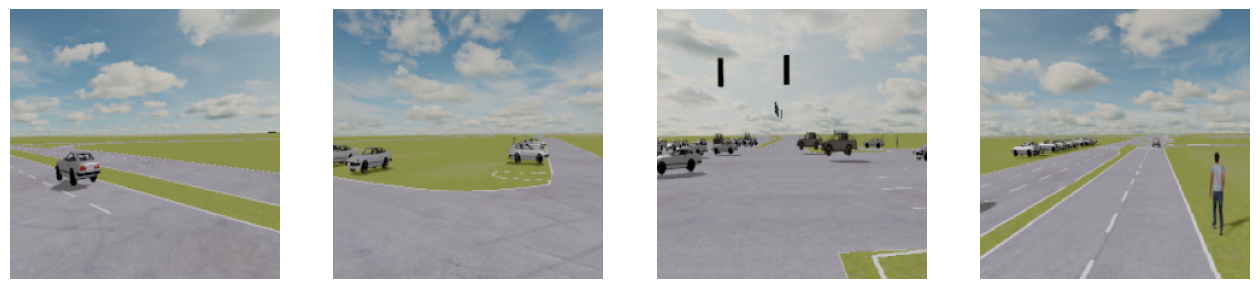

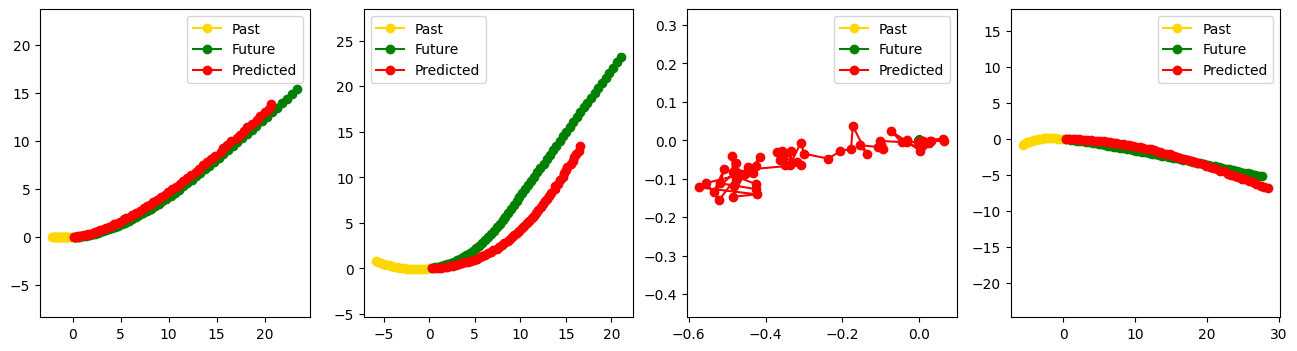

In [ ]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)
command = val_batch_zero['command'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, history, command)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        pred_future = model(camera, history, command)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
